In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import math
import sys # For error handling


# --- Constants ---
N_SEGMENTS = 50
R_MIN = 40.0e-6  # Minor radius of prolate ellipse body in m
L_WORM = 1.0e-3  # Length of worm in m
N_RODS = N_SEGMENTS + 1


In [2]:
# --- Geometry Function R[i] ---
# Precompute R values for efficiency as it's called repeatedly
R_array = np.zeros(N_RODS)
for i_py in range(N_RODS): # i_py is 0-based python index
    i_math = i_py + 1 # Corresponding 1-based index for the formula
    # Argument for ArcCos, adjusted for 1-based index 'i_math'
    arg = (i_math - (N_SEGMENTS / 2.0 + 1.0)) / (N_SEGMENTS / 2.0 + 0.2)
    # Clip argument to avoid domain errors for acos near ends
    arg = np.clip(arg, -1.0, 1.0)
    try:
        R_array[i_py] = R_MIN * abs(math.sin(math.acos(arg)))
    except ValueError as e:
        print(f"Warning: math domain error for R[{i_math}] (index {i_py}). Arg: {arg}. Setting R=0.", file=sys.stderr)
        R_array[i_py] = 0.0 # Assign a default value on error

In [3]:
def R_func(i_1based):
    """
    Returns the precomputed radius for the given 1-based rod index.
    Handles bounds checking.
    """
    if 1 <= i_1based <= N_RODS:
        return R_array[i_1based - 1]
    else:
        # Handle out-of-bounds index if necessary, maybe return 0 or raise error
        print(f"Warning: R_func called with out-of-bounds index {i_1based}", file=sys.stderr)
        return 0.0

In [4]:
# --- Visualization Function ---
def display_worm_model(ax, Ss, colors):
    """
    Draws the worm model on the provided Matplotlib Axes object.

    Args:
        ax: The Matplotlib Axes to draw on.
        Ss: NumPy array of shape (N_RODS, 3) containing [x, y, phi] for each rod.
        colors: A dictionary or list containing colors for different parts.
                Expected keys/indices: 'rods', 'diag', 'head_d', 'head_v',
                                       'vnc1_d', 'vnc1_v', 'other_d', 'other_v'
    """
    if Ss.shape != (N_RODS, 3):
         raise ValueError(f"Input state Ss has incorrect shape: {Ss.shape}. Expected ({N_RODS}, 3)")

    x = Ss[:, 0]
    y = Ss[:, 1]
    phi = Ss[:, 2]

    # Calculate Dorsal (PDs) and Ventral (PVs) point coordinates efficiently
    cos_phi = np.cos(phi)
    sin_phi = np.sin(phi)
    R_vals = R_array # Use precomputed array

    AllPDs_x = x + R_vals * cos_phi
    AllPDs_y = y + R_vals * sin_phi
    AllPDs = np.stack((AllPDs_x, AllPDs_y), axis=-1)

    AllPVs_x = x - R_vals * cos_phi
    AllPVs_y = y - R_vals * sin_phi
    AllPVs = np.stack((AllPVs_x, AllPVs_y), axis=-1)

    # Define segment indices (0-based Python)
    head_end = 8   # Corresponds to Mathematica index 8
    vnc1_end = 16  # Corresponds to Mathematica index 16

    # Create slices for different parts
    HeadPDs = AllPDs[0:head_end]
    VNC1PDs = AllPDs[head_end:vnc1_end]
    OtherPDs = AllPDs[vnc1_end:]

    HeadPVs = AllPVs[0:head_end]
    VNC1PVs = AllPVs[head_end:vnc1_end]
    OtherPVs = AllPVs[vnc1_end:]

    # --- Drawing ---
    # Clear previous drawings
    ax.cla()

    # 1. Rods (Lines between PDs and PVs)
    rod_color = colors.get('rods', 'gray') # Default color
    rod_lw = 2.0 # Corresponds to Thickness[0.003] visually scaled
    for i in range(N_RODS):
        ax.plot([AllPDs[i, 0], AllPVs[i, 0]], [AllPDs[i, 1], AllPVs[i, 1]],
                color=rod_color, linewidth=rod_lw, solid_capstyle='round')

    # 2. Diagonal Connections
    diag_color = colors.get('diag', 'lightgray')
    diag_lw = 1.0 # Corresponds to Thickness[0.002]
    # Diagonal 1: PD[i] to PV[i+1] (Drop last PD, Drop first PV)
    for i in range(N_RODS - 1):
        ax.plot([AllPDs[i, 0], AllPVs[i+1, 0]], [AllPDs[i, 1], AllPVs[i+1, 1]],
                color=diag_color, linewidth=diag_lw, solid_capstyle='round')
    # Diagonal 2: PD[i+1] to PV[i] (Drop first PD, Drop last PV)
    for i in range(N_RODS - 1):
        ax.plot([AllPDs[i+1, 0], AllPVs[i, 0]], [AllPDs[i+1, 1], AllPVs[i, 1]],
                color=diag_color, linewidth=diag_lw, solid_capstyle='round')

    # 3. Segmented Outlines
    outline_lw = 1.5 # Corresponds to Thickness[0.002]
    # Head
    if len(HeadPDs) > 1:
        ax.plot(HeadPDs[:, 0], HeadPDs[:, 1], color=colors.get('head_d', 'red'), linewidth=outline_lw)
    if len(HeadPVs) > 1:
        ax.plot(HeadPVs[:, 0], HeadPVs[:, 1], color=colors.get('head_v', 'blue'), linewidth=outline_lw)
    # VNC1
    if len(VNC1PDs) > 1:
        ax.plot(VNC1PDs[:, 0], VNC1PDs[:, 1], color=colors.get('vnc1_d', 'orange'), linewidth=outline_lw)
    if len(VNC1PVs) > 1:
        ax.plot(VNC1PVs[:, 0], VNC1PVs[:, 1], color=colors.get('vnc1_v', 'cyan'), linewidth=outline_lw)
    # Other
    if len(OtherPDs) > 1:
        ax.plot(OtherPDs[:, 0], OtherPDs[:, 1], color=colors.get('other_d', 'darkgray'), linewidth=outline_lw)
    if len(OtherPVs) > 1:
        ax.plot(OtherPVs[:, 0], OtherPVs[:, 1], color=colors.get('other_v', 'darkgray'), linewidth=outline_lw)

    # Set aspect ratio and limits (can be done outside update for static limits)
    ax.set_aspect('equal', adjustable='box')
    # ax.axis('off') # Turn off axes like Mathematica

In [5]:
# --- Load Data ---
data_file = "body.dat"
try:
    # Skip header rows if any, typically there isn't one for this format
    data = np.loadtxt(data_file)
    if data.ndim == 1: # Handle case with only one line of data
        data = data.reshape(1, -1)
    print(f"Loaded data from '{data_file}' with shape: {data.shape}")
    # Expected shape: (num_timesteps, 1 + 3 * N_RODS)
    expected_cols = 1 + 3 * N_RODS
    if data.shape[1] != expected_cols:
         print(f"Warning: Expected {expected_cols} columns, but found {data.shape[1]}", file=sys.stderr)
         # Decide how to proceed: error out or try to use it?
         # sys.exit(1) # Option: Exit if format is wrong

except FileNotFoundError:
    print(f"Error: Data file '{data_file}' not found.", file=sys.stderr)
    sys.exit(1)
except Exception as e:
    print(f"Error loading data file '{data_file}': {e}", file=sys.stderr)
    sys.exit(1)

Loaded data from 'body.dat' with shape: (1521, 154)


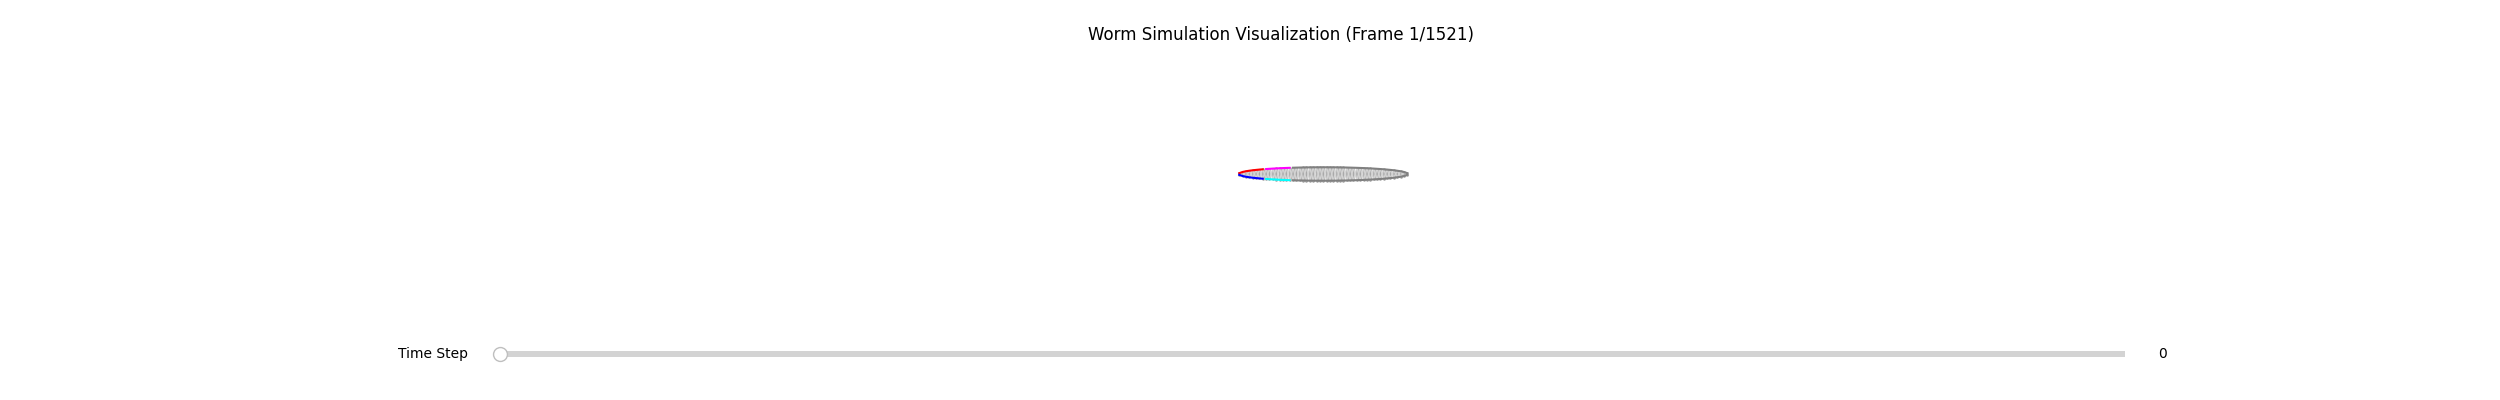

In [7]:
# --- Setup Plot and Slider ---
fig, ax = plt.subplots(figsize=(25, 4)) # Adjust figsize for aspect ratio
plt.subplots_adjust(bottom=0.25) # Make room for slider

# Define colors (adjust as needed)
# Mathematica's cd[[1]] etc. aren't defined, so using descriptive names/defaults
colors = {
    'rods': 'darkgray',
    'diag': 'lightgray',
    'head_d': 'red',
    'head_v': 'blue',
    'vnc1_d': 'magenta',
    'vnc1_v': 'cyan',
    'other_d': 'gray',
    'other_v': 'gray'
}

# Plot Range and Aspect Ratio (similar to Mathematica)
w_plot = 0.0015 # Adjusted width for better visualization based on L_WORM=0.001
# Define ranges based on w_plot
x_min, x_max = -L_WORM * 0.6, L_WORM * 1.1 # Heuristic based on worm length / movement
y_min, y_max = -w_plot/2 , w_plot/2
# Aspect ratio setting is done via ax.set_aspect('equal') in the display function
# The plot range might need tuning based on actual worm movement in data

# Initial plot (frame 0)
initial_time_index = 0
num_frames = data.shape[0]
if num_frames > 0:
    # Reshape data for the first frame: skip time (col 0), reshape rest
    Ss_initial = data[initial_time_index, 1:].reshape((N_RODS, 3))
    display_worm_model(ax, Ss_initial, colors)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
else:
    print("Warning: No data loaded to display.", file=sys.stderr)

ax.set_title(f"Worm Simulation Visualization (Frame {initial_time_index+1}/{num_frames})")
ax.axis('off') # Hide axes

# Create slider axes
ax_slider = plt.axes([0.2, 0.1, 0.65, 0.03], facecolor='lightgoldenrodyellow')

# Create slider
slider = Slider(
    ax=ax_slider,
    label='Time Step',
    valmin=0,
    valmax=num_frames - 1 if num_frames > 0 else 0,
    valinit=initial_time_index,
    valstep=1 # Integer steps
)

# Update function for the slider
def update(val):
    time_index = int(slider.val) # Get integer index from slider
    if 0 <= time_index < num_frames:
        Ss_current = data[time_index, 1:].reshape((N_RODS, 3))
        display_worm_model(ax, Ss_current, colors) # Redraw worm
        # Re-apply limits and aspect ratio after cla()
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_aspect('equal', adjustable='box') # Re-apply aspect ratio
        ax.set_title(f"Worm Simulation Visualization (Frame {time_index+1}/{num_frames})")
        ax.axis('off') # Hide axes again
        fig.canvas.draw_idle() # Update the figure display
    else:
        print(f"Warning: Slider index {time_index} out of range.", file=sys.stderr)


# Register the update function with the slider
slider.on_changed(update)

# Show the plot
plt.show()

ValueError: could not convert string to float: 'Evaluating'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\claus\source\repos\CE_locomotion_py\viz.py", line 4, in <module>
    e = np.loadtxt("fitness.dat")
        ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\claus\source\repos\CE_locomotion_py\.venv\Lib\site-packages\numpy\lib\_npyio_impl.py", line 1395, in loadtxt
    arr = _read(fname, dtype=dtype, comment=comment, delimiter=delimiter,
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\claus\source\repos\CE_locomotion_py\.venv\Lib\site-packages\numpy\lib\_npyio_impl.py", line 1046, in _read
    arr = _load_from_filelike(
          ^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string 'Evaluating' to float64 at row 0, column 1.
